In [1]:
import numpy as np
import pandas as pd
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
#glove2word2vec(glove_input_file="embeddings/glove/glove.twitter.27B.50d.txt", word2vec_output_file="embeddings/glove/gensim_glove.twitter.27B.50d.txt")

In [3]:
glove_model = KeyedVectors.load_word2vec_format("embeddings/glove/gensim_glove.twitter.27B.50d.txt", binary=False)

In [4]:
with open('data/train.jsonl') as f:
    train_data = pd.read_json(f, lines=True)
with open('data/test.jsonl') as f:
    test_data = pd.read_json(f, lines=True)

In [5]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(train_data['label'])
y_train = keras.utils.to_categorical(y, num_classes=2)

In [6]:
train_data['context'] = train_data['context'].str.join(' ')
test_data['context'] = test_data['context'].str.join(' ')

In [7]:
#np.percentile([len(seq) for seq in tokenizer.texts_to_sequences(train_data['context'])], 95)

In [8]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH_RESPONSE = 65
MAX_SEQUENCE_LENGTH_CONTEXT = 300
MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH_RESPONSE + MAX_SEQUENCE_LENGTH_CONTEXT

tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, lower = False)
tokenizer.fit_on_texts(train_data['response'])
tokenizer.fit_on_texts(train_data['context'])
tokenizer.fit_on_texts(test_data['response'])
tokenizer.fit_on_texts(test_data['context'])
X_train_resp = sequence.pad_sequences(tokenizer.texts_to_sequences(train_data['response']), maxlen=MAX_SEQUENCE_LENGTH_RESPONSE)
X_train_cont = sequence.pad_sequences(tokenizer.texts_to_sequences(train_data['context']), maxlen=MAX_SEQUENCE_LENGTH_CONTEXT)
#X_train = np.hstack((X_train_resp, X_train_cont))
X_test_resp = sequence.pad_sequences(tokenizer.texts_to_sequences(test_data['response']), maxlen=MAX_SEQUENCE_LENGTH_RESPONSE)
X_test_cont = sequence.pad_sequences(tokenizer.texts_to_sequences(test_data['context']), maxlen=MAX_SEQUENCE_LENGTH_CONTEXT)
#X_test = np.hstack((X_test_resp, X_test_cont))

In [9]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 46985 unique tokens.


In [10]:
EMBEDDING_DIM = glove_model.vector_size

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in glove_model.vocab:
        embedding_matrix[i] = glove_model[word]

In [15]:
batch_size = 8
input_response = keras.Input(batch_shape=(batch_size, MAX_SEQUENCE_LENGTH_RESPONSE), dtype="int32")
embed_response = layers.Embedding(len(word_index) + 1,
                          EMBEDDING_DIM,
                          weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH_RESPONSE,
                          trainable=False)(input_response)
input_context = keras.Input(batch_shape=(batch_size, MAX_SEQUENCE_LENGTH_CONTEXT), dtype="int32")
embed_context = layers.Embedding(len(word_index) + 1,
                          EMBEDDING_DIM,
                          weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH_CONTEXT,
                          trainable=False)(input_context)
x = layers.Concatenate(axis = 1)([embed_response ,embed_context])
x = layers.Conv1D(EMBEDDING_DIM, 3, kernel_initializer='he_normal', padding='valid',
                        activation='sigmoid')(x)
x = layers.Conv1D(EMBEDDING_DIM, 3, kernel_initializer='he_normal', padding='valid',
                        activation='sigmoid')(x)
x = layers.Dropout(0.25)(x)
x = layers.LSTM(128, kernel_initializer='he_normal', activation='sigmoid', dropout=0.5,
               return_sequences=True)(x)
x = layers.LSTM(128, kernel_initializer='he_normal', activation='sigmoid', dropout=0.5)(x)
x = layers.Dense(128, kernel_initializer='he_normal', activation='sigmoid')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = keras.Model([input_response, input_context], predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('No of parameter:', model.count_params())
print(model.summary())

No of parameter: 4953702
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(8, 65)]            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(8, 300)]           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (8, 65, 50)          2349300     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (8, 300, 50)         2349300     input_6[0][0]                    
______________________________________________________________

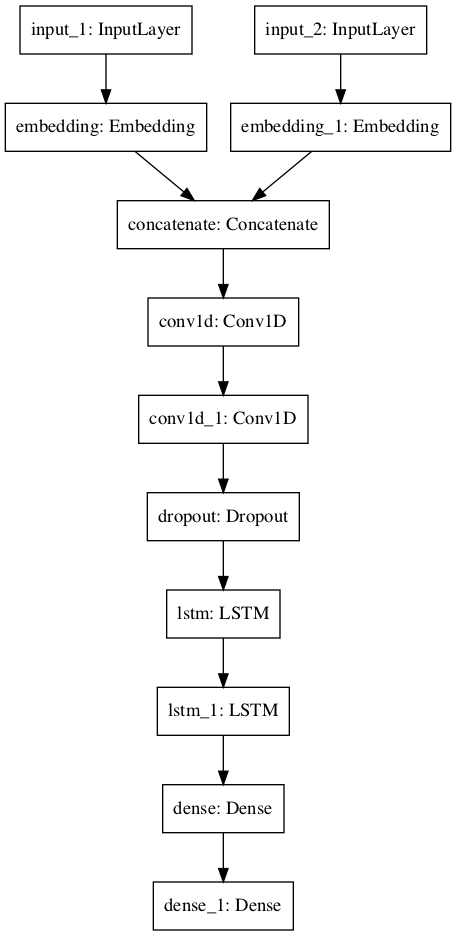

In [12]:
keras.utils.plot_model(model, to_file='model.png')

In [16]:
modelCheckpoint = ModelCheckpoint('best_sarcasm_model.hdf5', save_best_only = True)
model.fit([X_train_resp, X_train_cont], y_train, batch_size=batch_size, epochs=100, validation_split=0.2 , shuffle=True, callbacks=[modelCheckpoint])

500/500 [==============================] - 81s 162ms/step - loss: 0.6714 - accuracy: 0.6180 - val_loss: 1.1383 - val_accuracy: 0.0000e+00


In [ ]:
epochs = 100
init_learning_rate = 1e-3

input_response = keras.Input(batch_shape=(batch_size, MAX_SEQUENCE_LENGTH_RESPONSE), dtype="int32")
embed_response = layers.Embedding(len(word_index) + 1,
                          EMBEDDING_DIM,
                          weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH_RESPONSE,
                          trainable=False)(input_response)
input_context = keras.Input(batch_shape=(batch_size, MAX_SEQUENCE_LENGTH_CONTEXT), dtype="int32")
embed_context = layers.Embedding(len(word_index) + 1,
                          EMBEDDING_DIM,
                          weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH_CONTEXT,
                          trainable=False)(input_context)
x = layers.Concatenate(axis = 1)([embed_response ,embed_context])
sentence_rep = layers.GRU(500)(x)
h_sar = layers.Dense(300, activation='relu')(sentence_rep)
h_sen = layers.Dense(300, activation='relu')(sentence_rep)



sarcasmBranch = layers.Dense(2, activation='softmax', name="sarcasm_output")(x)
losses = {
    "sarcasm_output": "categorical_crossentropy",
    "sentiment_output": "categorical_crossentropy",
}
lossWeights = {"sarcasm_output": 2.0, "sentiment_output": 1.0}
opt = Adam(lr=init_learning_rate, decay=init_learning_rate / epochs)
model2 = keras.Model([input_response, input_context], outputs=[sarcasmBranch, sentimentBranch])
model2.compile(loss=losses, lossWeights = lossWeights optimizer=opt, metrics=['accuracy'])
print('No of parameter:', model.count_params())
print(model2.summary())